In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/515k-hotel-reviews-data-in-europe/Hotel_Reviews.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from tqdm.notebook import tqdm
import nltk
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import gensim

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stop = stopwords.words('english')
stem = SnowballStemmer('english')

In [5]:
predf = pd.read_csv('/kaggle/input/515k-hotel-reviews-data-in-europe/Hotel_Reviews.csv')

In [6]:
predf['review'] = predf["Negative_Review"] + predf["Positive_Review"]
predf['target'] = 1*(predf["Reviewer_Score"]>5)

In [7]:
predf['review'] = predf['review'].apply(lambda x: " ".join([token for token in re.sub('[^A-Za-z0-9\s]','', x).strip().split() if token not in stop]))

In [8]:
reviews = [rev.split() for rev in predf.review]
w2v = gensim.models.word2vec.Word2Vec(vector_size=300, window=7, min_count=10, workers=8)
w2v.build_vocab(reviews)

In [9]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [10]:
w2v.train(reviews, total_examples=len(reviews), epochs=32)

(283489242, 343242720)

In [11]:
train, test = train_test_split(predf, test_size=0.3, random_state=42)

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.review)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 69486


In [13]:
rev_train = pad_sequences(tokenizer.texts_to_sequences(train.review), maxlen=300)
rev_test = pad_sequences(tokenizer.texts_to_sequences(test.review), maxlen=300)

In [14]:
sent_train = train.target
sent_test = test.target

In [15]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v.wv:
    embedding_matrix[i] = w2v.wv[word]
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [16]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2023-01-02 12:48:04.987563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 12:48:05.113597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 12:48:05.114370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 12:48:05.116630: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          20845800  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 21,006,301
Trainable params: 160,501
Non-trainable params: 20,845,800
_________________________________________________________________


In [17]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [18]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [19]:
%%time
history = model.fit(rev_train, sent_train,
                    batch_size=1024,
                    epochs=32,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

2023-01-02 12:48:08.388492: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/32
318/318 [==============================] - 370s 1s/step - loss: 0.1692 - accuracy: 0.9407 - val_loss: 0.1418 - val_accuracy: 0.9508
Epoch 2/32
318/318 [==============================] - 358s 1s/step - loss: 0.1363 - accuracy: 0.9496 - val_loss: 0.1337 - val_accuracy: 0.9515
Epoch 3/32
318/318 [==============================] - 363s 1s/step - loss: 0.1320 - accuracy: 0.9503 - val_loss: 0.1298 - val_accuracy: 0.9511
Epoch 4/32
318/318 [==============================] - 365s 1s/step - loss: 0.1425 - accuracy: 0.9467 - val_loss: 0.1312 - val_accuracy: 0.9511
Epoch 5/32
318/318 [==============================] - 365s 1s/step - loss: 0.1304 - accuracy: 0.9508 - val_loss: 0.1313 - val_accuracy: 0.9516
Epoch 6/32
318/318 [==============================] - 363s 1s/step - loss: 0.1281 - accuracy: 0.9517 - val_loss: 0.1303 - val_accuracy: 0.9523
Epoch 7/32
318/318 [==============================] - 364s 1s/step - loss: 0.1270 - accuracy: 0.9520 - val_loss: 0.1306 - val_accuracy: 0.9524

In [20]:
%%time
score = model.evaluate(rev_test, sent_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

152/152 [==============================] - 12s 79ms/step - loss: 0.1264 - accuracy: 0.9529

ACCURACY: 0.9528767466545105
LOSS: 0.12642861902713776
CPU times: user 10.9 s, sys: 573 ms, total: 11.5 s
Wall time: 12.2 s


In [21]:
def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    return float(score)

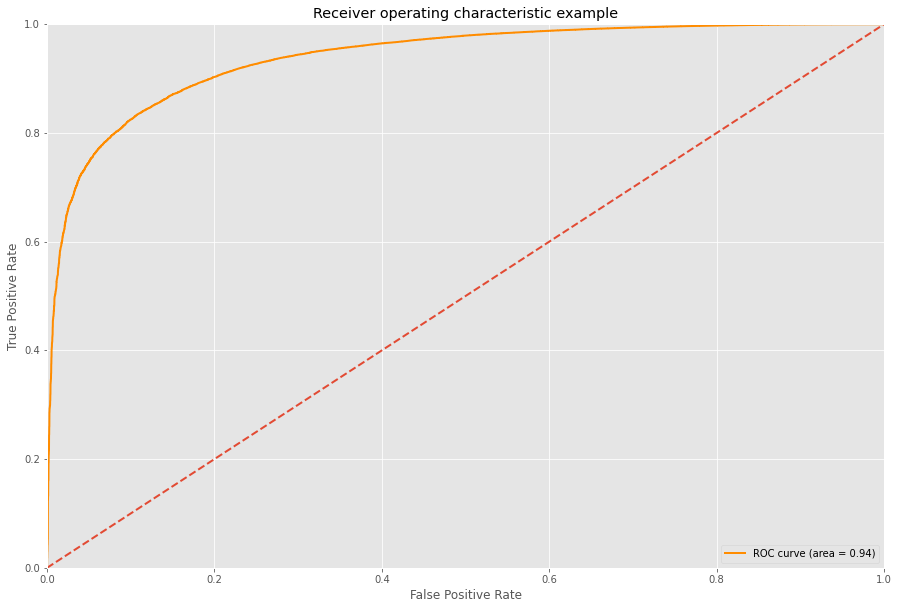

In [22]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

sent_pred = model.predict(rev_test)
fpr, tpr, thresholds = roc_curve(sent_test, sent_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.59')

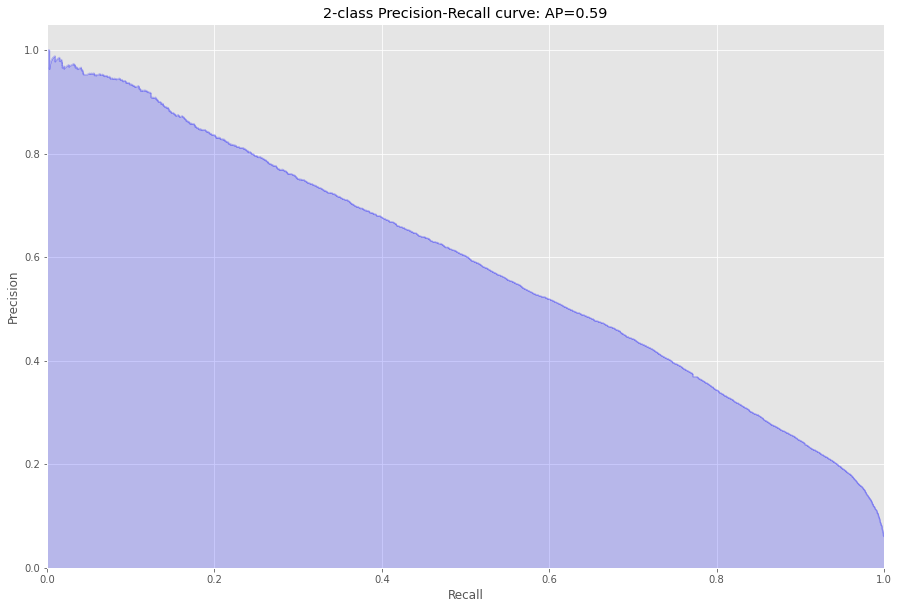

In [27]:
from sklearn.metrics import average_precision_score, precision_recall_curve

average_precision = average_precision_score(1-sent_test, 1-sent_pred)

precision, recall, _ = precision_recall_curve(1-sent_test, 1-sent_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [35]:
model.save('model.h5')

In [38]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)